In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter

import _pickle as cPickle
import scipy

from scipy.optimize import curve_fit
from scipy.signal import detrend


from glob import glob
import random

import os


(211001, 4)
(3025, 4)
printed: (55, 110) 
printed: (55, 110) 
Printed (55, 110)


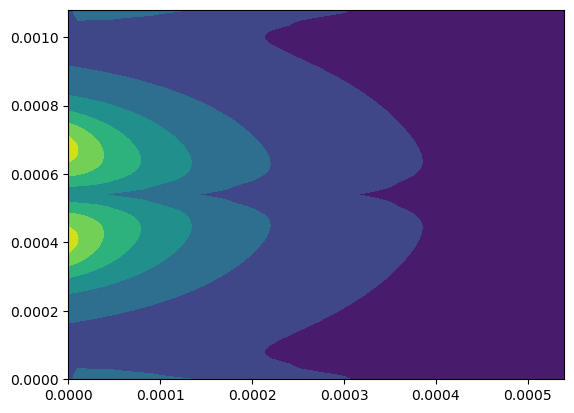

In [198]:
x = 0.0004258026478661925 
y = 0.0003758985538919442

root = "./data/One_coil.csv"
m = 3.5/(10*3.3*0.3)*1e-6
rot_matrix = np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2)],[np.sin(-np.pi/2), np.cos(-np.pi/2)]])

df = pd.read_csv(root, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
#drop not needed
print(df.shape)
df.drop(df[df["y"].values < (0.0035 - 1536*m)].index, inplace = True)
df.drop(df[df["x"].values > 0.00054].index, inplace = True)
print(df.shape)


df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

map_Bx = df["Bx"].values
map_By = df["By"].values

B = np.sqrt(map_Bx**2 + map_By**2)

map_x = df["x"].values
map_y = df["y"].values

mg_idx = np.where((map_x == np.round(x,5)) & (map_y == np.round(y,5)))
cB  = np.sqrt(map_Bx[mg_idx]**2 + map_By[mg_idx]**2)

xx = (np.max(map_y) - map_y).reshape( len(np.unique(map_x)), len(np.unique(map_y)) )
yy = map_x.reshape(len(np.unique(map_x)), len(np.unique(map_y)))
B = B.reshape(len(np.unique(map_x)), len(np.unique(map_y)))

xx_ = np.hstack((xx,xx))
yy_ = np.hstack((-yy[:,::-1], yy))
yy_ -= yy_.min() 
bb_ = np.hstack((B[:,::-1], B))

print("printed:", xx_.shape, "\nprinted:", yy_.shape, "\nPrinted", bb_.shape)

plt.contourf(xx_, yy_, bb_)


Text(0, 0.5, 'B (T)')

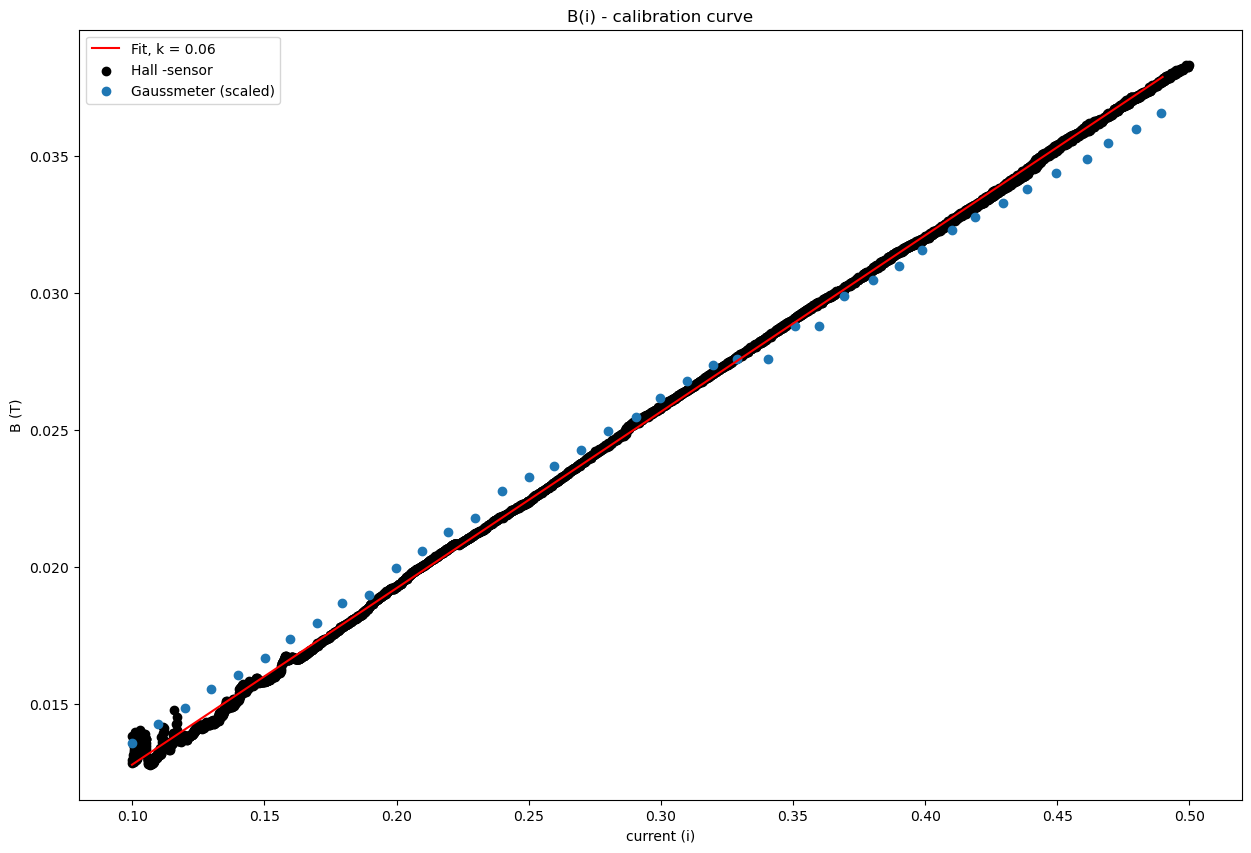

In [72]:
#load Calibration
fig, ax = plt.subplots(1, 1, figsize = (15,10))

patH = "./data/calib/calib_2023-10-20.npy"
df = pd.DataFrame(np.load(patH).T, columns = ['index','aim','measured','Mg', 'scaler'])
x, y, k, b, cut_min, cut_max = fit_calibration(df)

ax.plot(np.arange(np.min(x),np.max(x),1e-2),k*np.arange(np.min(x),np.max(x),1e-2)+b,color = "red", label = "Fit, k = {}".format(np.round(k,2)))
ax.scatter(x,y, color = "black", label = "Hall -sensor")


datapath = glob("./data/calib/*.csv")
Gauss = fetchDataCSV(datapath)
Gauss = Gauss.reset_index()
Gauss["GUSS_ValueNP"] *= 1e-4
df_g =Gauss.loc[cut_min/100:cut_max/100,:].reset_index()  

ax.scatter( x[::100], df_g["GUSS_ValueNP"]+b, label = "Gaussmeter (scaled)")

ax.legend()
ax.set_title("B(i) - calibration curve")
ax.set_xlabel("current (i)")
ax.set_ylabel("B (T)")

(40, 9)

In [55]:
cut_min

500

In [49]:
def fit_calibration(df):
    cut_off = 5*100
    maxIndex = np.where(df["measured"].values >=0.5)[0][0]
    x = df["measured"].values[cut_off:maxIndex]
    y = df["Mg"].values[cut_off:maxIndex]
    k, b  = np.polyfit(x,y, 1)
    
    return x, y, k, b, cut_off, maxIndex

def fetchDataNPY(paths):
    for i in range(len(paths)):
        datas = np.load(paths[i])
        print(datas, "\ni",i )
        if i == 0:
            df = pd.DataFrame(datas.T, columns = ['index','aim','measured','Mg'])
            df["measurement"] = i
        else:
            dftemp = pd.DataFrame(datas.T, columns = ['index','aim','measured','Mg'])
            dftemp["measurement"] = i
            df = pd.concat([df, dftemp])
    
    return df

def fetchDataCSV(paths):
    
    for i in range(len(paths)):
        if i == 0:
            df = pd.read_csv(paths[i], index_col = False)
            df["measurement"] = os.path.split(paths[i])[1].split("_")[1][:-4]
        else:
            dftemp =  pd.read_csv(paths[i], index_col = False)
            dftemp["measurement"] = os.path.split(paths[i])[1].split("_")[1][:-4]
            df = pd.concat([df, dftemp])
    return df
    
def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

def func(x, a, b):
    return a*np.tanh(x*b)


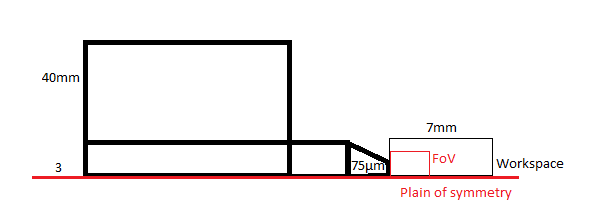

Force experienced by a magnetic bead in an external non-homogenous B. Here, we focus on 2D problem since microscope FoV limits observations to 2D projections.

$
\begin{align}
F_{bead} &= V \cdot M(B) \cdot \nabla B(x,y)
\end{align}
$

M - Magnetization of the bead (A/m), V - volume of the bead ($m^3$), and $\nabla$ B - magnetic field gradient. 

B depends on directly on i linearly or non-linearly depending on the core properties. Constant core permeability gives linear dependence between B and i$_input$ whereas B-H based core permeability suggests non-linear dependence which saturates at certain input current levels.

B is simulated using Comsol and Gaussian current loop technique. From Comsol: \textbf{B}(x,y,i = 0.5 A) and direction angle $\alpha$. From this $\nabla B_x$ and $\nabla B_y$ were derived and sampled based on {x,y} coordinates in the calculations. The spatial density of the simulation was 0.05mm ( $\partial x = \partial y = 5 \cdot 10^{-5}$)

$
\begin{align}
B_x &= B \cos( \alpha ) \\
B_y &= B \sin( \alpha ) \\
\nabla B &= [\frac{ \partial |B|}{\partial x}, \frac{ \partial |B|}{\partial y} ]
\end{align}
$

M(B) can be derived from magnetization measurements which give magnetic moment ($m$) as a function of magnetic field intensity ($H$). Here, we calculate both mass and volumetric magnetization. Mass magnetization is used to compare with tds and volumetric in calculations.

$
\begin{align}
M_{\text{mass}} &= \frac{m}{mass} \\
M_{\text{volumetric}} &= \frac{m}{V}
\end{align}
$

A displacement model for a magnetic bead was used to simulate the bead dispalcement in the field. Both x and y coordinates were managed independently.

k - number of timestep
dt - length of timestep
$\rho$ - density
s$_{k, \text{bead}}$ - bead position
v$_{k, \text{bead}}$ - bead velocity
a$_{k, \text{bead}}$ - bead acceleration

$
\begin{align}
f_{\text{bead}} &= mass \cdot a \rightarrow a = \frac{f_{\text{bead}}}{mass} = \frac{f_{\text{bead}}}{\rho \cdot V_{\text{bead}}} \\
s_{k, \text{bead}}  &= s_{k-1, \text{bead}} + v_{k-1, \text{bead}}*dt + \frac{f}{m}*dt^2 \\
v_{k, \text{bead}} &= v_{k-1, \text{bead}} + \frac{f}{m}*dt \\
\end{align}
$


Mechanocal pareameters were derived from simulated and experimental displacement data using 1) classical micromechnical models 1.0) without B adjustment and 1.1) with B adjustment. Without B adjustment moving bead do not experience constant magnetic gradient since nonhomogenous B. Here, assumptions of constant force in previous studies are evaluated.

Creep:

kelvin-Voigt model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= \frac{1}{E}*(1-e^{\frac{-E t}{n}}) \\
\epsilon_{\text{Burger's}} (t) &= \sigma \left( \frac{1}{E_1} + \frac{t}{n_1} + \frac{1}{E_2} (1 - e^{ \frac{-E_2 t}{n_2}}) \right)
\end{align}
$

Relaxation:

maxwell model and burger model:

$
\begin{align}
\epsilon_{\text{Kelvin-Voigt}} (t) &= E e^{ \frac{- E t}{n}} \\
\epsilon_{\text{Burger's}} (t) &= 
\end{align}
$

Response to 

1) I - Step with current feedback and Step with B feedback
2) B - Step with current feedback and Step with B feedback
2) Sin wave with current feedback and Step with B feedback
3) Calibration slope between B and current and Magnetic sensor



Text(0, 0.5, 'B (T)')

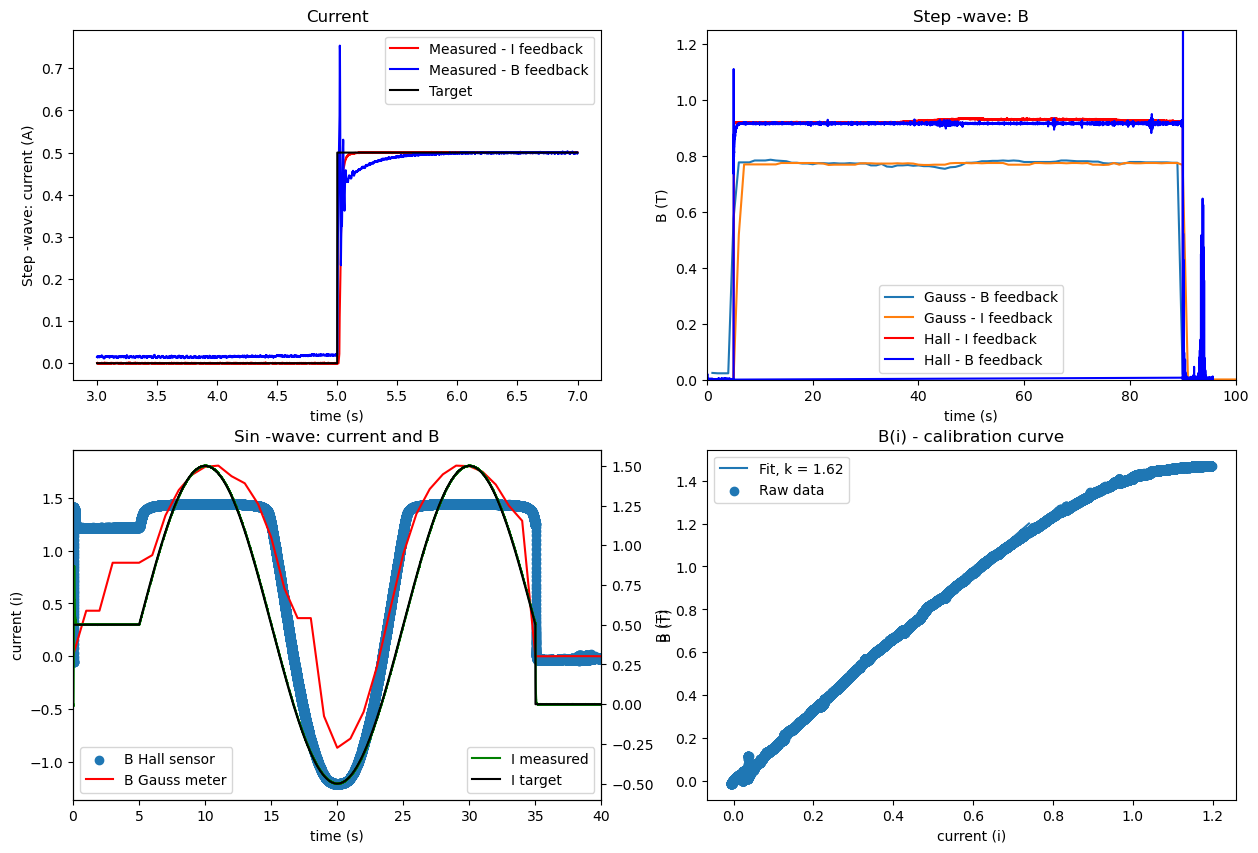

In [3]:
#Load Mg Step
pathH = "./data/M1_StepB.npy"
pathG = "./data/M1_StepB.csv"

MgHall = pd.DataFrame(np.load(pathH).T, columns = ['index','aim','measured','Mg'])
MgGauss = pd.read_csv(pathG, index_col = False)

#Load I step

pathH = "./data/M1_StepCurrent.npy"
pathG = "./data/M1_StepCurrent.csv"

CurrentHall = pd.DataFrame(np.load(pathH).T, columns = ['index','aim','measured','Mg'])
CurrentGauss = pd.read_csv(pathG, index_col = False)

MgGauss["GUSS_ValueNP"] = MgGauss["GUSS_ValueNP"]*1e-3
CurrentGauss["GUSS_ValueNP"] = CurrentGauss["GUSS_ValueNP"]*1e-3



fig, ax  = plt.subplots(2, 2, figsize = (15,10))

start = 3000
end = 7000

target = np.ones(end-start)*0.68
target[:2000] = 0

ax[0,0].set_title("Current")

ax[0,0].plot(CurrentHall["index"][start:end],CurrentHall["measured"][start:end], color = "red", label = "Measured - I feedback")
ax[0,0].plot(MgHall["index"][start:end],MgHall["measured"][start:end]*1.35, color = "blue", label = "Measured - B feedback")
ax[0,0].plot(CurrentHall["index"][start:end],CurrentHall["aim"][start:end], color = "black", label = "Target")

ax[0,0].set_ylabel("Step -wave: current (A)")
ax[0,0].set_xlabel("time (s)")
ax[0,0].legend()


ax[0,1].plot(MgGauss["Idx"],MgGauss["GUSS_ValueNP"]*1.35, label = "Gauss - B feedback")
ax[0,1].plot(CurrentGauss["Idx"],CurrentGauss["GUSS_ValueNP"], label = "Gauss - I feedback")

ax[0,1].plot(CurrentHall["index"],CurrentHall["Mg"], color = "red", label = "Hall - I feedback")
ax[0,1].plot(MgHall["index"],MgHall["Mg"]*1.35, color = "blue", label = "Hall - B feedback")

ax[0,1].set_xlim([0,100])
ax[0,1].set_ylim([0,1.25])

ax[0,1].set_title("Step -wave: B")
ax[0,1].set_ylabel("B (T)")
ax[0,1].set_xlabel("time (s)")
ax[0,1].legend()

#Load sin wave
dataBd = "./data/sinWave.csv"
datas = pd.read_csv(dataBd, index_col = False)

paths = "./data/sinWave.npy"
df = pd.DataFrame(np.load(paths).T, columns = ['index','aim','measured','Mg'])

datas["GUSS_Value"] = datas["GUSS_Value"]*(-1)
df["Mg"] = df["Mg"]

ax[1,0].scatter(df["index"],df["Mg"], label = "B Hall sensor")
ax[1,0].plot(datas["Idx"]-8, datas["GUSS_Value"]*1e-3, color = "red", label = "B Gauss meter")

ax[1,0].set_xlim([0,40])
ax_twin = ax[1,0].twinx()

num = 50000
ax_twin.plot(df["index"][:-num],df["measured"][:-num], color = "green", label = "I measured")
ax_twin.plot(df["index"][:-num], df["aim"][:-num], color = "black", label = "I target")


ax[1,0].set_title("Sin -wave: current and B")
ax[1,0].set_xlabel("time (s)")
ax[1,0].set_ylabel("current (i)")
ax[1,0].legend(loc = "lower left")

ax_twin.set_xlabel("time (s)")
ax_twin.set_ylabel("B (T)")
ax_twin.legend(loc = "lower right")


#load Calibration
patH = "./data/calibration_example.npy"
df = pd.DataFrame(np.load(patH).T, columns = ['index','aim','measured','Mg'])
B_coef, x, y, k = fit_calibration(np.load(patH))

ax[1,1].plot(np.arange(0,np.max(x),1e-2),k*np.arange(0,np.max(x),1e-2), label = "Fit, k = {}".format(np.round(k[0],2)))
ax[1,1].scatter(df["measured"]-df["measured"][0], df["Mg"]-df["Mg"][0], label = "Raw data")
ax[1,1].legend()

ax[1,1].set_title("B(i) - calibration curve")
ax[1,1].set_xlabel("current (i)")
ax[1,1].set_ylabel("B (T)")



Core extension dependence (Linearity) 

Dependence of magnetic field and sensor distance

(0.0, 115.0)

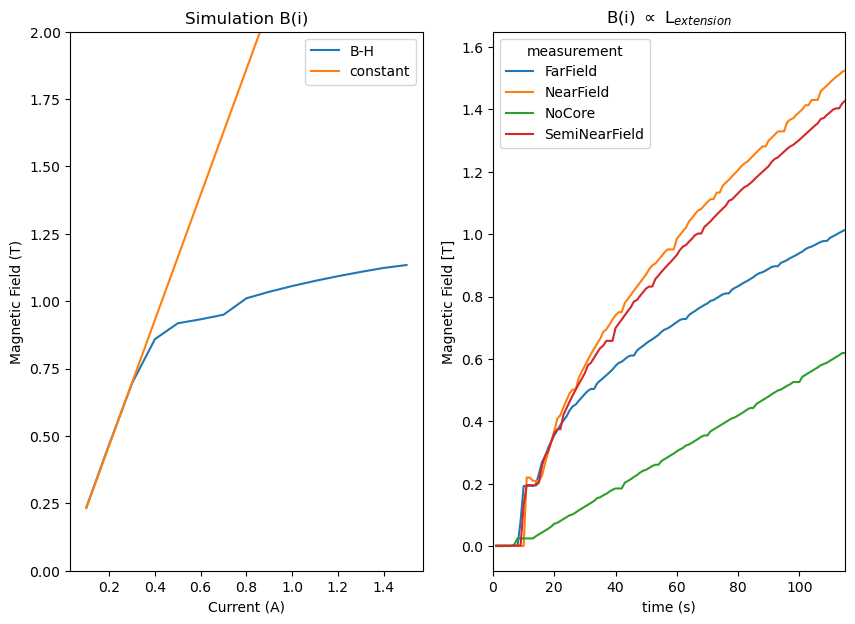

In [4]:
file =  "./data/One_coil_slope_constant.csv"
df = pd.read_csv(file, sep = ",", skiprows= range(9), names = ["t", "B"])
df["type"] = "constant"

file =  "./data/One_coil_slope.csv"
df_sub = pd.read_csv(file, sep = ",", skiprows= range(9), names = ["t", "B"])
df_sub["type"] = "B-H"
df = pd.concat((df,df_sub))

fig, ax  = plt.subplots(1, 2, figsize = (10,7))

types = df["type"].unique()

k= 0.1

for count,i in enumerate(df.groupby("type")):
    name, i = i
    ax[0].plot(k*i["t"].values, i["B"].values, label = name)

ax[0].legend()
ax[0].set_ylim([0,2])
ax[0].set_xlabel("Current (A)")
ax[0].set_ylabel("Magnetic Field (T)")
ax[0].set_title("Simulation B(i)")


datapath = glob("./data/extension_calib/*.csv")
Gauss = fetchDataCSV(datapath)
Gauss = Gauss.reset_index()
Gauss["GUSS_ValueNP"] *= 1e-3

sns.lineplot(data = Gauss, x = "Idx", y = "GUSS_ValueNP", hue = "measurement", ax = ax[1])

ax[1].set_title(r'B(i) $ \propto $ L$_{extension}$')
ax[1].set_ylabel("Magnetic Field [T]")
ax[1].set_xlabel("time (s)")
ax[1].set_xlim([0,115])

Single Particle tracker - Step 

1) Displacement (without and with linear feedback)
2) Estimated feedback value as function of time
3) Current with feedback
4) Magnetic field with feedback
5) simulation of particle displacements

***Need real measurements from the core***

C:\Users\Asentaja\AppData\Local\Temp\ipykernel_10540\3757211605.py:40: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(h, label = "B magnitude [T]")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


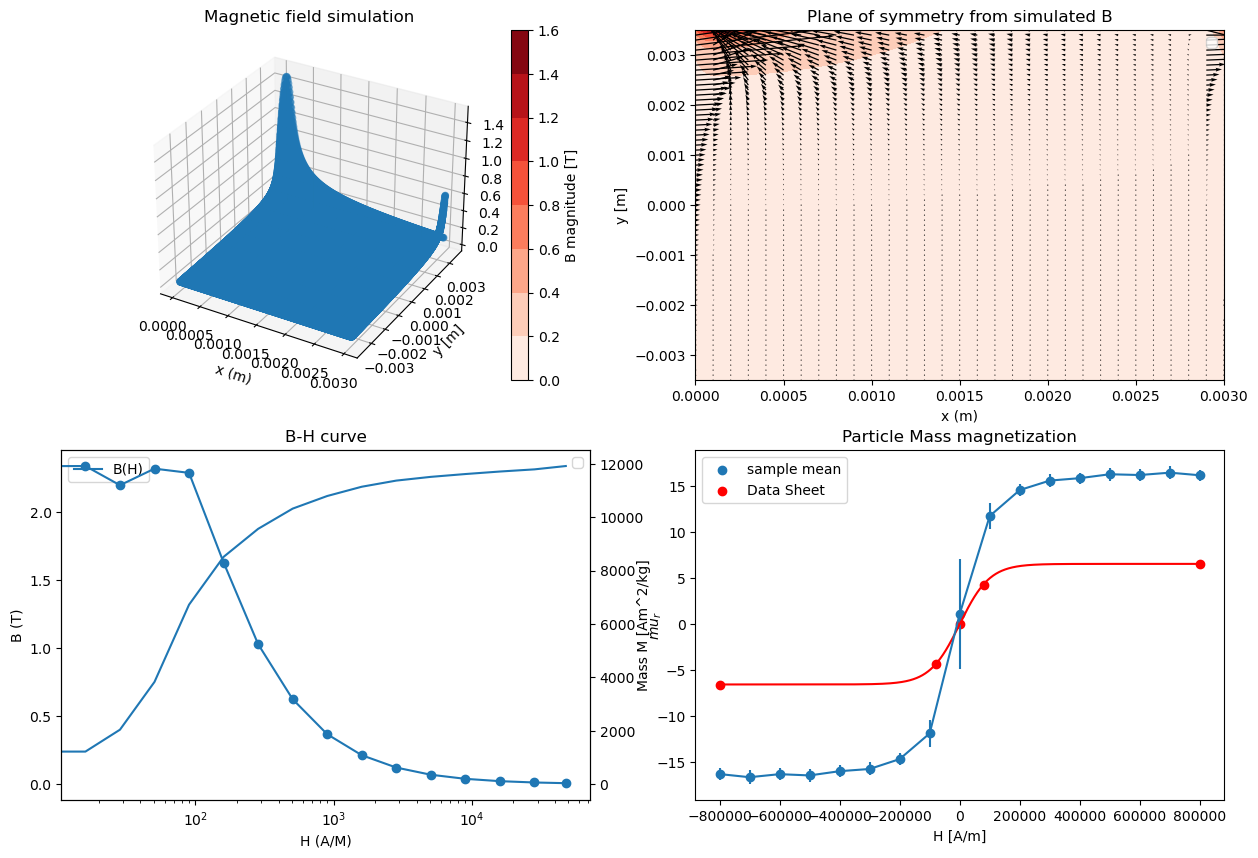

In [21]:
file =  "./data/One_coil.csv"

df = pd.read_csv(file, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])

#df["y"] -= max(df["y"].values)
#df["y"] = np.abs(df["y"])

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

ax[0,0].remove()
ax[0,0]=fig.add_subplot(2,2,1,projection='3d')
ax[0,0].scatter(df["x"], df["y"], np.sqrt(df["By"]**2 + df["Bx"]**2))
ax[0,0].set_xlabel("x (m)"); ax[0,0].set_ylabel("y [m]"); ax[0,0].set_zlabel("B [T]")
ax[0,0].set_title("Magnetic field simulation")


df["B"] = np.sqrt(df["By"]**2 + df["Bx"]**2)

df["angle"] = np.arctan2(df["Bx"], df["By"])

coord_x = df["x"].unique()
coord_y = df["y"].unique()

xx, yy = np.meshgrid(coord_x, coord_y)

data = np.array(df["B"].values).reshape(len(coord_y),len(coord_x))

data_x = np.array(df["Bx"].values).reshape(len(coord_y),len(coord_x))
data_y = np.array(df["By"].values).reshape(len(coord_y),len(coord_x))

angle = np.array(df["angle"].values).reshape(len(coord_y),len(coord_x))

h = ax[0,1].contourf(xx, yy, data, cmap = "Reds")
cbar = fig.colorbar(h, label = "B magnitude [T]")

dBx = scipy.ndimage.gaussian_filter(np.gradient(data, (1e-5), axis  = 0),5)#*np.sin(angle)
dBy = scipy.ndimage.gaussian_filter(np.gradient(data, (1e-5), axis  = 1),5)#*np.cos(angle)

phase = 10
ax[0,1].quiver(xx[::phase, ::phase], yy[::phase,::phase], dBy[::phase,::phase], dBx[::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]

ax[0,1].set_title("Plane of symmetry from simulated B")
ax[0,1].set_xlabel("x (m)"); ax[0,1].set_ylabel("y [m]")
ax[0,1].legend()

df_sim = df 


#B-H curve B = \mu_0*(H+M)

df = pd.read_csv("./data/core_H_B.csv", sep= ",")
df["mu"] = df["B"]/(df["H"]*(1.25663706212e-6))
df["mu"][0] = 0

ax[1,0].plot(df["H"],df["B"], label = "B(H)")
ax[1,0].set_xlabel("H (A/M)")
ax[1,0].set_ylabel("B (T)")
ax[1,0].set_title("B-H curve")
ax[1,0].set_xscale("log")

ax_1 = ax[1,0].twinx()
ax_1.plot(df["H"],df["mu"])
ax_1.scatter(df["H"],df["mu"])
ax_1.set_ylabel(r"$mu_r$")

ax[1,0].legend()
ax_1.legend()

# Units https://www.nist.gov/system/files/documents/pml/electromagnetics/magnetics/magnetic_units.pdf
paths = glob("./data/*.dat")

#These are magnetization values for the beads for micromod data sheet
mgM = np.array([-6.6, -4.3, 0, 4.3, 6.6]) #Mass magnetization
mgH = np.array([-800e3, -80e3, 0, 80e3, 800e3])

for count,i in enumerate(paths):
    end = i.split("\\")[1]
    parts = end.split("_")
    day = parts[0]
    size = float(parts[1][:-7])*1e-6
    weight = float(parts[2][:-6])*1e-8 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["size"] = size
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start = np.where(df_sub["H"][:125].values>600e3)[0][0]

    end = np.argmax(df_sub["H"][:125].values)
    k = np.polyfit(df_sub["H"][start:end].values,df_sub["moment"][start:end].values-df_sub["moment"][start:end].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]
    df_sub["moment"] = df_sub["moment"] - offset
    #print(weight)
    df_sub["M_mass"] = df_sub["moment"]/(weight)
    df_sub["M"] =  df_sub["moment"]/(4/3*np.pi*(size/2)**3) #A/m

    #plt.plot(df_sub["H"],df_sub["M_mass"], label = "measured sample {}".format(count))
    if count == 0:
        df =df_sub
    else:
        df = pd.concat((df,df_sub))


df["H_round"] = np.round(df["H"].values, -5)
fd_mean = df.groupby(["H_round"]).mean().reset_index()
error = df.groupby(["H_round"]).std()["M_mass"].values

ax[1,1].errorbar(fd_mean["H_round"],fd_mean["M_mass"], yerr = error)
ax[1,1].scatter(fd_mean["H_round"],fd_mean["M_mass"], label = "sample mean")
ax[1,1].scatter(mgH,mgM, color = "red", label = "Data Sheet")
xdata = np.linspace(-800000,800000,1000)
popt, pcov = curve_fit(func, mgH, mgM, bounds = [[0,1/100000],[8,1/5000]])
ax[1,1].plot(xdata, func(xdata, *popt),color = "red")
M = func(xdata, *popt)
ax[1,1].set_xlabel("H [A/m]")
ax[1,1].set_ylabel("Mass M [Am^2/kg]")
ax[1,1].set_title("Particle Mass magnetization")

ax[1,1].legend()

df_mag = df





In [28]:
class particle:

    def __init__(self,x,y, dt, np_steps):
        self.s_x = x
        self.s_y = y

        self.v_x = 0
        self.v_y = 0

        self.step = 0

        self.position_history = np.zeros((2,np_steps))

        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

        size = 30*1e-6
        rho = 1.3 * 1000 # kg/m^3

        V = 4/3*np.pi*(size/2)**3

        self.vis = 1

        self.m = rho*V*1e3
        self.dt = dt



    def new_pos(self,f_x, f_y):
        
        self.s_x = self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2
        print("stepping x", self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2)


        self.v_x =self.v_x + f_x/self.m*self.dt
    
        self.s_y = self.s_y + self.v_y*self.dt + f_y/self.m*self.dt**2
        self.v_y = self.v_y + f_y/self.m*self.dt

        print("stepping y", self.s_x + self.v_x*self.dt + f_x/self.m*self.dt**2)

        self.position_history[0,self.step] = self.s_x
        self.position_history[1,self.step] = self.s_y

    def add_drag(self, v):

        f_d = 3*np.pi*self.vis*size*v

        return -f_d

    def get_position(self):
        return self.s_x,self.s_y
    
    def add_noise(self):
        self.s_x +=  np.random.normal(0,1e-7)
        self.s_y +=  np.random.normal(0,1e-7)

    def get_history(self):
        return self.position_history

closest mu -728220.8765863936
grads 16.28747300058768 18.398740328626566
Forces 7.548646432970879e-10 8.527141414007755e-10
stepping x 0.00011008214730895455
stepping y 0.00011012322096343183
New position 0.00011004107365447728 8.004639783611908e-05
closest mu -728220.8765863936
grads 16.28747300058768 18.398740328626566
Forces 7.548646432970879e-10 8.527141414007755e-10
stepping x 0.00011020536827238637
stepping y 0.00011024644192686365
New position 0.00011012322096343183 8.013919350835723e-05
closest mu -728220.8765863936
grads 16.28747300058768 18.398740328626566
Forces 7.548646432970879e-10 8.527141414007755e-10
stepping x 0.00011036966289029547
stepping y 0.00011041073654477275
New position 0.00011024644192686365 8.027838701671446e-05
closest mu -728220.8765863936
grads 16.28747300058768 18.398740328626566
Forces 7.548646432970879e-10 8.527141414007755e-10
stepping x 0.00011057503116268184
stepping y 0.00011061610481715913
New position 0.00011041073654477275 8.046397836119076e-05


(0.0, 0.0002715151515151515)

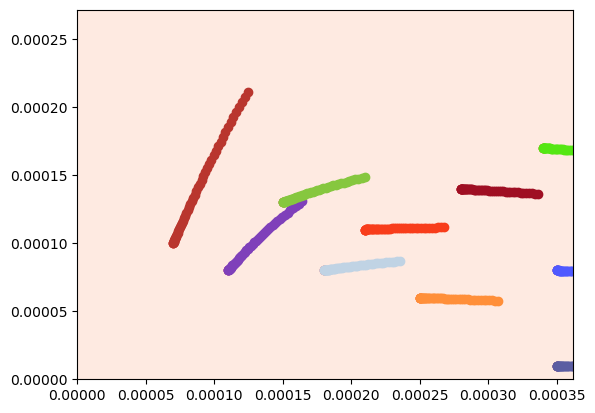

In [31]:
pixel_size = 3.5/(20*3.3*0.3)
FoV_x = 2048*pixel_size*1e-6
FoV_y = 1536*pixel_size*1e-6

mu_0 = 4*np.pi*1e-7

steps = 10
dt = 1

num_sim = 10

beads = []

number_of_colors = num_sim

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

plt.contourf(xx, yy, data, cmap = "Reds")


for i in range(num_sim):

    x_pos = np.round(np.random.uniform(0,FoV_x),5)
    y_pos = np.round(np.random.uniform(0,FoV_y),5)

    bead = particle(x_pos, y_pos, 1e-3, steps)

    x_, y_ = bead.get_position()

    plt.scatter(x_, y_, label = "step 0", c = "red")

    for steps in range(50):
        try:
            x_idx = np.where((xx == np.round(x_pos,5)) & (yy ==  np.round(y_pos,5)))[0][0]
            y_idx = np.where((xx ==  np.round(x_pos,5)) & (yy ==  np.round(y_pos,5)))[1][0]

            B_current = data[x_idx, y_idx]
            H_current = B_current/mu_0

            mu_idx = np.argmin(H_current-fd_mean["H"].values)
            #print("closest mu", np.min(H_current-fd_mean["H"].values)) #This has problems

            mu_current = fd_mean["M"].values[mu_idx]

            #print("grads", dBx[x_idx,y_idx], dBy[x_idx,y_idx])

            F_field_x = 4/3*np.pi*(size/2)**3*mu_current*mu_0*dBx[x_idx,y_idx]
            F_field_y = 4/3*np.pi*(size/2)**3*mu_current*mu_0*dBy[x_idx,y_idx]

            #print("Forces",F_field_x,F_field_y)

            bead.new_pos(F_field_x,F_field_y)

            x_pos, y_pos = bead.get_position()

            p#rint("New position", x_pos, y_pos )

            plt.scatter(x_pos, y_pos, label = "step {} bead {}".format(steps, k), c = color[i] )
        except:
            break
        
    beads.append(bead)

#plt.legend(fontsize = 2)

plt.xlim([0, FoV_x])
plt.ylim([0, FoV_y])


        



Micromechanical models

1) classic fit 
    -kelvin-Voigt creep
    -Maxwell relaxation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


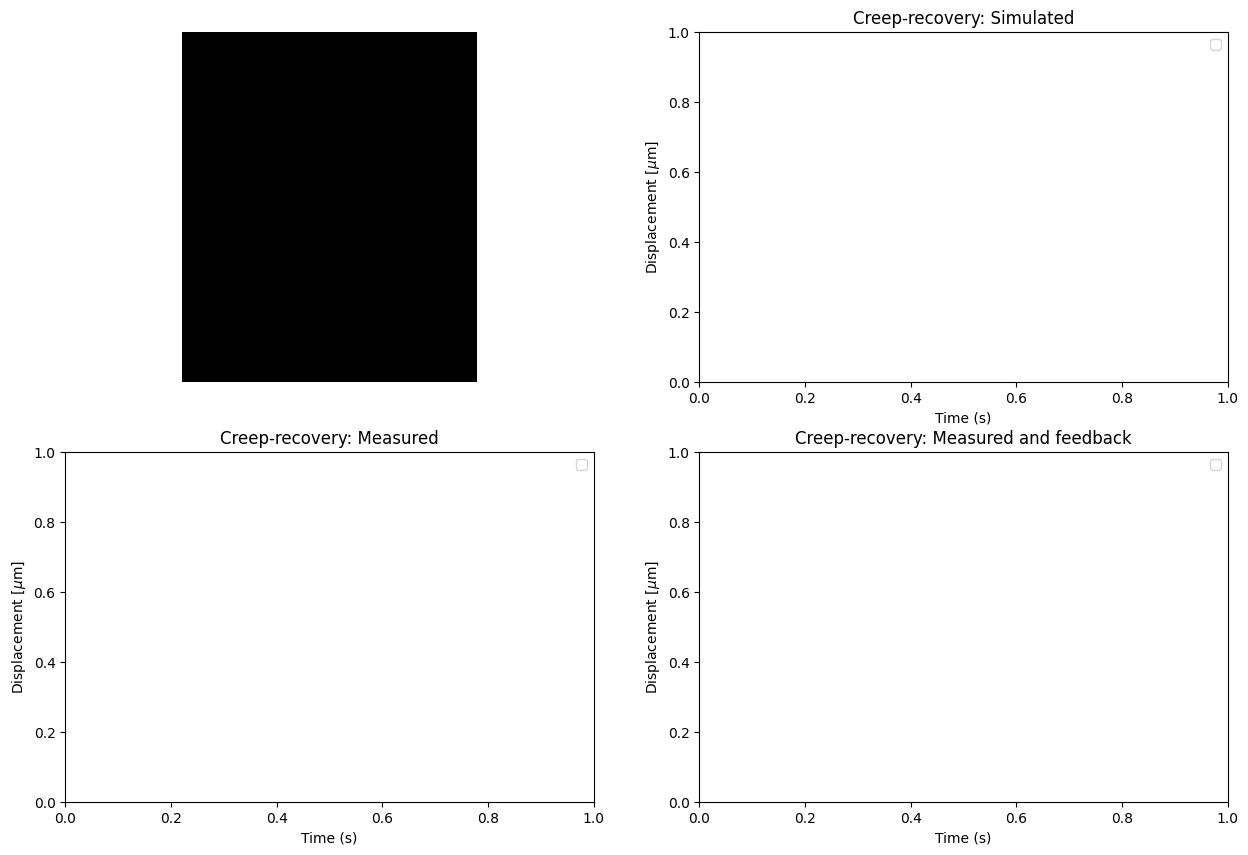

In [90]:
""""
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"
path_track = "./test/trackingData.pickle"

file_driver = np.load(path_driver)
file_frame = np.load(path_frame)

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])
df_track = pd.DataFrame.from_dict(file_track)

df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] = df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40



rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")

t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)
p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep]-df_track["time"][start_creep:end_creep].values[0], df_track["distance"][start_creep:end_creep], method = "dogbox")
creep_label = "Kelvin-Voigt:\nD: {}\ntau: {}".format(p[1],p[0]) 
plt.plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = creep_label)


plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep
rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)
p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:] - df_track["time"][start_rel:].values[0], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
rel_label = "Maxwell relaxation:\nE: {}\ntau: {}".format(p[1],p[0]) 

plt.plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = rel_label)

"""
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

# example_img = cv2.imread("./data/example_img.png")
# ax[0,0].imshow(example_img)

ax[0,0].imshow(np.zeros((2046,1720,3)))
ax[0,0].axis("off")

ax[0,1].set_title("Creep-recovery: Simulated")
ax[0,1].set_xlabel("Time (s)")
ax[0,1].set_ylabel(r'Displacement [$\mu$m]')
ax[0,1].legend()

ax[1,0].set_title("Creep-recovery: Measured")
ax[1,0].set_xlabel("Time (s)")
ax[1,0].set_ylabel(r'Displacement [$\mu$m]')
ax[1,0].legend()

ax[1,1].set_title("Creep-recovery: Measured and feedback")
ax[1,1].set_xlabel("Time (s)")
ax[1,1].set_ylabel(r'Displacement [$\mu$m]')
ax[1,1].legend()




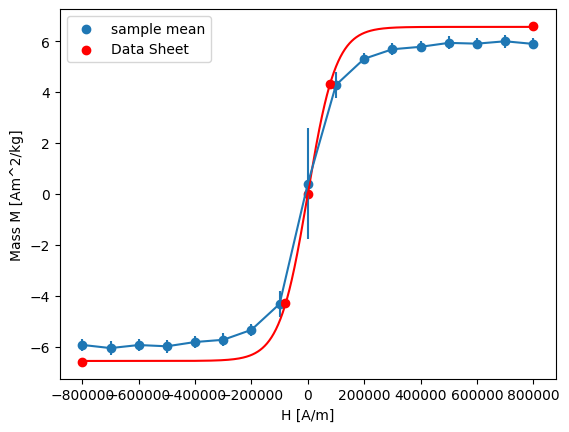

In [181]:
# Units https://www.nist.gov/system/files/documents/pml/electromagnetics/magnetics/magnetic_units.pdf
paths = glob("./data/*.dat")

#These are magnetization values for the beads for micromod data sheet
mgM = np.array([-6.6, -4.3, 0, 4.3, 6.6]) #Mass magnetization
mgH = np.array([-800e3, -80e3, 0, 80e3, 800e3])

for count,i in enumerate(paths):
    end = i.split("\\")[1]
    parts = end.split("_")
    day = parts[0]
    size = float(parts[1][:-7])*1e-6
    weight = float(parts[2][:-6])*1e-6*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,31)).iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["size"] = size
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start = np.where(df_sub["H"][:125].values>600e3)[0][0]

    end = np.argmax(df_sub["H"][:125].values)
    k = np.polyfit(df_sub["H"][start:end].values,df_sub["moment"][start:end].values-df_sub["moment"][start:end].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]
    df_sub["moment"] = df_sub["moment"] - offset
    #print(weight)
    df_sub["M_mass"] = df_sub["moment"]/(weight)
    df_sub["M"] =  df_sub["moment"]/(4/3*np.pi*(size/2)**3)
    #plt.plot(df_sub["H"],df_sub["M_mass"], label = "measured sample {}".format(count))
    if count == 0:
        df =df_sub
    else:
        df = pd.concat((df,df_sub))


df["H_round"] = np.round(df["H"].values, -5)
fd_mean = df.groupby(["H_round"]).mean().reset_index()
error = df.groupby(["H_round"]).std()["M_mass"].values

plt.errorbar(fd_mean["H_round"],fd_mean["M_mass"], yerr = error)
plt.scatter(fd_mean["H_round"],fd_mean["M_mass"], label = "sample mean")

plt.scatter(mgH,mgM, color = "red", label = "Data Sheet")
xdata = np.linspace(-800000,800000,1000)
popt, pcov = curve_fit(func, mgH, mgM, bounds = [[0,1/100000],[8,1/5000]])
plt.plot(xdata, func(xdata, *popt),color = "red")
M = func(xdata, *popt)

plt.xlabel("H [A/m]")
plt.ylabel("Mass M [Am^2/kg]")

plt.legend()



In [71]:
10**-3 - 1e-3

0.0

Micromechanical models fits on displacements

In [ ]:
#path_calib = "./test/calib.npy"
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"
path_track = "./test/trackingData.pickle"

#file_calib = np.load(path_calib)
file_driver = np.load(path_driver)
file_frame = np.load(path_frame)

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])
df_track = pd.DataFrame.from_dict(file_track)

df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] =df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40

rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)

p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep]-df_track["time"][start_creep:end_creep].values[0], df_track["distance"][start_creep:end_creep], method = "dogbox")
plt.plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = "Kelvin-Voigt")

print("Kelvin-Voigt:\n D: ", p[1], "\ntau: ", p[0] )

#p, p_ = curve_fit(maxwell, df_track["time"][start_creep:end_creep], df_track["distance"][start_creep:end_creep], method = "dogbox")
#plt.plot(t_hat, maxwell(t_hat,*p), label = "Maxwell")

#print("Maxwell:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Creep-recovery")
plt.xlabel("Time (s)")
plt.ylabel(r"Displacement ($\mu$m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep

rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)
#t_hat_rel -= t_hat_rel[0]

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:] - df_track["time"][start_rel:].values[0], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = "Maxwell rel")
print("Maxwell relaxation:\n E: ", p[1], "\ntau: ", p[0] )

plt.legend()
plt.show()

#plt.plot(df_current["offset"])


Multiple particle tracker - Ossi derivation

Kelvin-Voigt:
 D:  0.9614515143057517 
tau:  2.358000522314679
Maxwell relaxation:
 E:  25.50004625894535 
tau:  0.9850670537921418


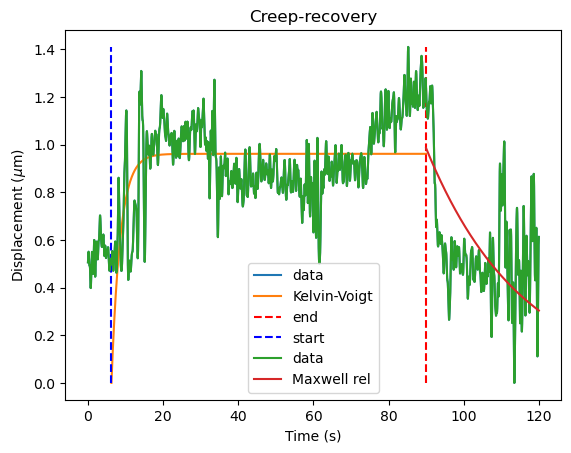

In [22]:
import datetime
print(datetime.datetime.now().date)

<built-in method date of datetime.datetime object at 0x0000014AA1CC5DB0>


Maxwell relaxation:
 D:  [-1.85831945  6.96092928] 
tau:  [ 0.49941154 -1.85831945]


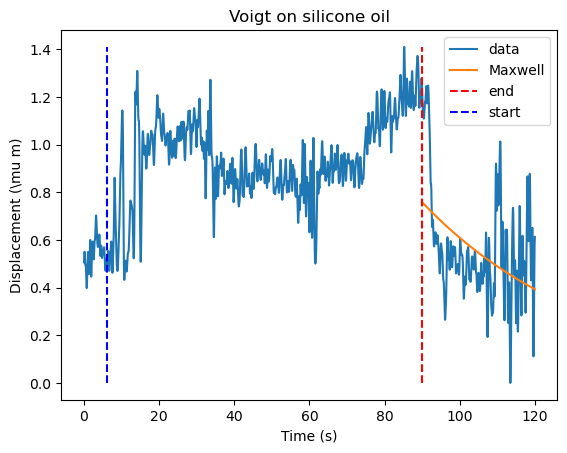

In [172]:
start_rel = end_creep

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:], df_track["distance"][start_rel:], bounds=([0,0], [1e3, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel,*p), label = "Maxwell")

print("Maxwell relaxation:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Voigt on silicone oil")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (\mu m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

plt.legend()
plt.show()

#plt.plot(df_current["offset"])



In [3]:
file =  "./data/One_coil.csv"


df = pd.read_csv(file, sep = ",", skiprows= [0,1], names = ["x", "y", "By", "Bx"])
#drop not needed
df.drop(df[df["y"].values < (3.5-0.9)*1e-3].index, inplace = True)
df.drop(df[df["x"].values > 0.3*1e-3].index, inplace = True)

df["y"] -= max(df["y"].values)
df["y"] = np.abs(df["y"])

df["x"] = np.round(df["x"],5)
df["y"] = np.round(df["y"],5)

df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

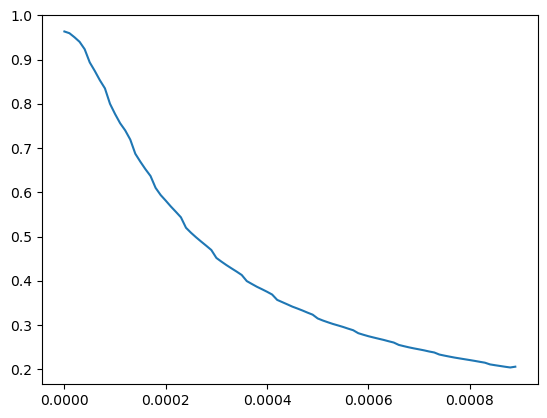

In [4]:
mask = df["x"] == 0
plt.plot(df["y"][mask],df["By"][mask])

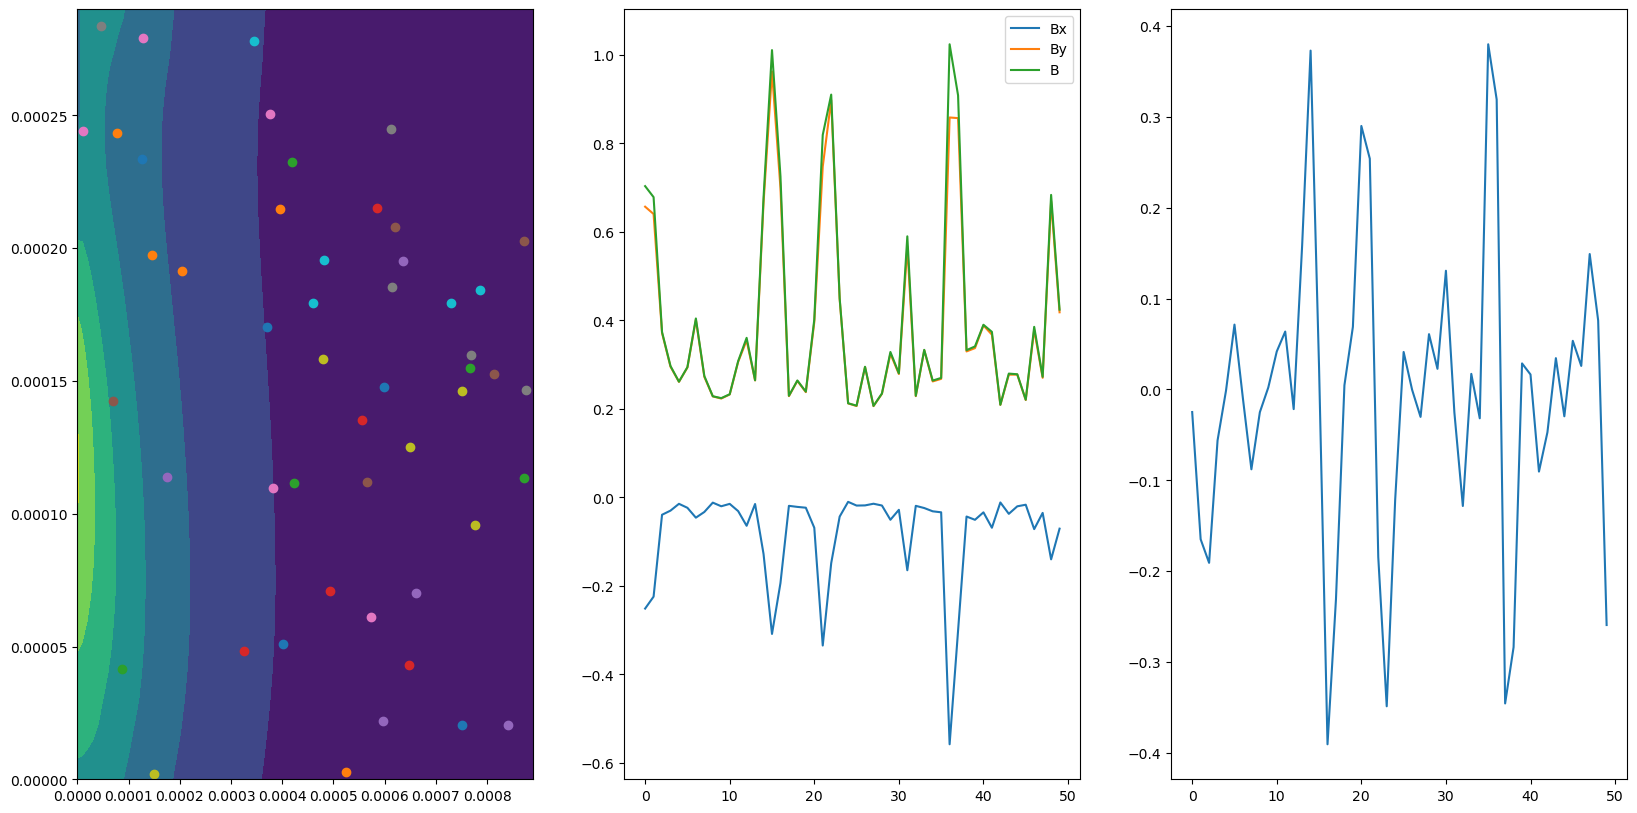

In [5]:
fig, ax = plt.subplots(1,3, figsize = (20,10))

center = 0.5e-5

x = np.random.uniform(low=0, high=max(df["x"].values), size=(50,))
y = np.abs(np.random.uniform(low=0, high=max(df["y"].values), size=(50,)) - center)

x_val = np.zeros(50)
y_val = np.zeros(50)
tot_B = np.zeros(50)

xx, yy = np.meshgrid(df["x"].unique(), df["y"].unique())
data = np.array(df["By"].values).reshape(len(df["y"].unique()),len(df["x"].unique()))
ax[0].contourf(yy,xx, data)

for i in range(len(x)):
    h = ax[0].scatter(y[i],x[i])
    mg_idx = np.where((df["x"].values == np.round(x[i],5)) & (df["y"].values == np.round(y[i],5)))
    x_val[i] =  df["Bx"].values[mg_idx]
    y_val[i] =  df["By"].values[mg_idx]

    tot_B[i] = np.sqrt(x_val[i]**2 + y_val[i]**2)


ax[1].plot(np.arange(50), x_val, label = "Bx")
ax[1].plot(np.arange(50), y_val, label = "By")
ax[1].plot(np.arange(50), tot_B, label = "B")
ax[1].legend()

ax[2].plot(np.gradient(tot_B))


#h.colorbar()


In [6]:
error

NameError: name 'error' is not defined